/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Features with high VIF (>10) to be removed: ['Total Store Sq Ft', 'Sales Floor Sq Ft', 'Girls Sq Ft', 'Guys Sq Ft', 'Accessories Sq Ft', 'Population Est CrYr', 'Sex Males CrYr', 'Sex Females CrYr', 'Age Average CrYr', 'Unemployment Rate', 'Average Household Income CrYr', 'Householder under 25 years:', 'Householder 25 to 44 years:', 'Family Inc: Aggregate Average', 'Per Capita Income CrYr', 'Wealth: Average Household', 'Poverty: In poverty', 'Male 14 to 35 CrYr', 'Female 14 to 35 CrYr', 'Total Pop 14 to 35 CrYr', 'Under 25 Low Income', 'Under 25 Med Income', 'Under 25 High Income', '25 to 44 Low Income', '25 to 44 Med Income', '25 to 44 High Income', 'Pop class_Urban', 'Guys Segmentation_On Trend', 'Girls Segmentation_On Trend', 'ChangeMade_no change']
Selected features by RFE: ['Transient Pop Est', 'Pop class_Suburban', 'Centre Type_Strip', 'Climate_Frigid', 'Climate_Hot', 'Climate_Moderate', 'Climate_Warm', 'Guys Segmentation_On trend', 'ChangeMade_relocation', 'ChangeMade_remodel']



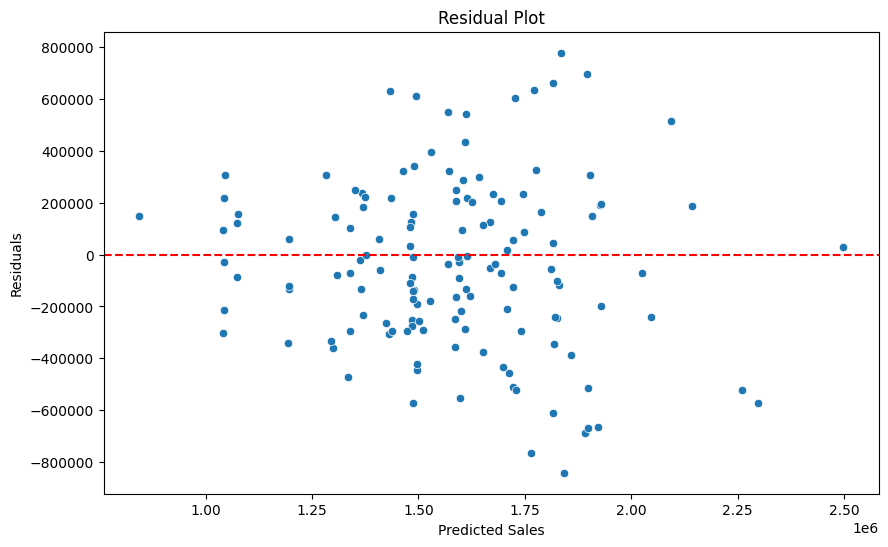


Results saved to 'model_results.xlsx'


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import uuid

# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate VIF
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = data.columns
    vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# Loading the dataset
data = pd.read_excel('Data.xlsx', sheet_name='Data')

# Dropping irrelevant columns
data = data.drop(['Store ID', 'ChangeDate'], axis=1)

# Separate features and target
X = data.drop('Sales', axis=1)
y = data['Sales']

# Identify categorical columns
categorical_cols = ['Pop class', 'Centre Type', 'Climate', 'Guys Segmentation', 'Girls Segmentation', 'ChangeMade']

# One hot encode categorical variables with dtype=int
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype=int)

# Handle missing values
X.replace(['NA', 'NaN', 'None', ''], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# Check for infinite values
if np.any(np.isinf(X)):
    print("Warning: Infinite values found. Replacing with NaN and dropping.")
    X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Remove features with high VIF (>10)
vif_data = calculate_vif(X)
high_vif = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
print("Features with high VIF (>10) to be removed:", high_vif)
X = X.drop(high_vif, axis=1)

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feature selection using RFE (select top 10 features)
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_].tolist()
print("Selected features by RFE:", selected_features)

# Use selected features for modeling
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)

# Calculate performance metrics
mape = calculate_mape(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print("\nModel Performance Metrics:")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Fit OLS model for detailed summary
X_train_ols = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_ols).fit()
print("\nOLS Model Summary:")
print(ols_model.summary())

# Residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.show()

# Analyze residuals by Centre Type
test_data = X_test.copy()
test_data['Sales'] = y_test
test_data['Predicted_Sales'] = y_pred
test_data['Residuals'] = residuals
test_indices = y_test.index
original_data = pd.read_excel('Data.xlsx', sheet_name='Data')
test_data['Centre Type'] = original_data.loc[test_indices, 'Centre Type']
residual_by_centre = test_data.groupby('Centre Type')['Residuals'].apply(lambda x: np.mean(np.abs(x))).reset_index(name='Mean Absolute Residual')

# Saving results to Excel
performance_metrics = pd.DataFrame({
    'Metric': ['MAPE (%)', 'MAE', 'RMSE', 'R²'],
    'Value': [mape, mae, rmse, r2]
})
coef_data = pd.DataFrame({
    'Feature': ['Intercept'] + selected_features,
    'Coefficient': [lr_model.intercept_] + list(lr_model.coef_)
})
with pd.ExcelWriter('model_results.xlsx') as writer:
    performance_metrics.to_excel(writer, sheet_name='Performance_Metrics', index=False)
    coef_data.to_excel(writer, sheet_name='Model_Coefficients', index=False)
    residual_by_centre.to_excel(writer, sheet_name='Residuals_by_Centre', index=False)

print("\nResults saved to 'model_results.xlsx'")